In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.amp import autocast, GradScaler
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Create transformations for data augmentation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.2, 0.2),
        scale=(0.8, 1.2),  # This approximates zoom_range and brightness_range
    ),
    transforms.ColorJitter(brightness=0.2),  # brightness adjustment
    transforms.ToTensor(),  # Scales to [0,1]
])

# For validation and test, we only resize and normalize
val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # Scales to [0,1]
])

# Create dataset objects
train_dataset = datasets.ImageFolder(
    root='dataset/train',
    transform=train_transform
)

validation_dataset = datasets.ImageFolder(
    root='dataset/validation',
    transform=val_test_transform
)

test_dataset = datasets.ImageFolder(
    root='dataset/test',
    transform=val_test_transform
)

# Create data loaders
train_data = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

validation_data = DataLoader(
    validation_dataset,
    batch_size=32,
    shuffle=False
)

test_data = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

In [18]:
class DeepFakeDetector(nn.Module):
    def __init__(self, pretrained=True, dropout_rate=0.5):
        super(DeepFakeDetector, self).__init__()
        # Load pretrained MobileNetV3
        if pretrained:
            self.backbone = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
        else:
            self.backbone = models.mobilenet_v3_large()
        
        # Get the number of output channels from the backbone
        # Run a dummy forward pass to get the actual output channels
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 256, 256)
            features_shape = self.backbone.features(dummy_input).shape
            num_channels = features_shape[1]  # Get the channel dimension
        
        # Replace classifier
        in_features = self.backbone.classifier[0].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 1)
        )
        
        # Add attention mechanism with correct number of input channels
        self.attention = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Get features before pooling
        features = self.backbone.features(x)
        
        # Apply attention
        attention_mask = self.attention(features)
        attention_mask = attention_mask.expand_as(features)  # Match the channel dimension
        features = features * attention_mask + features
        
        # Continue with pooling and classification
        x = nn.functional.adaptive_avg_pool2d(features, (1, 1))
        x = torch.flatten(x, 1)
        x = self.backbone.classifier(x)
        return x

In [19]:
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4, device="cuda", 
                save_dir="checkpoints"):
    # Create directory for saving checkpoints
    os.makedirs(save_dir, exist_ok=True)
    
    # Initialize loss function, optimizer and scaler
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    scaler = GradScaler(device=device.type)
    
    # Initialize metrics tracking
    history = {
        'train_loss': [], 'train_acc': [], 'train_precision': [], 'train_recall': [], 'train_auc': [],
        'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_auc': [],
        'best_val_auc': 0
    }
    
    # Move model to device
    model = model.to(device)
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []
        train_preds = []
        train_labels = []
        train_probs = []
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.float().to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass with mixed precision
            with autocast(device_type=device.type):
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels)
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # Track metrics
            train_losses.append(loss.item())
            probs = torch.sigmoid(outputs).detach().cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            train_preds.extend(preds)
            train_labels.extend(labels.cpu().numpy())
            train_probs.extend(probs)
            
            # Update progress bar
            train_bar.set_postfix(loss=f"{np.mean(train_losses):.4f}")
        
        # Calculate training metrics
        train_acc = accuracy_score(train_labels, train_preds)
        train_precision = precision_score(train_labels, train_preds, zero_division=0)
        train_recall = recall_score(train_labels, train_preds, zero_division=0)
        train_auc = roc_auc_score(train_labels, train_probs)
        
        # Validation phase
        model.eval()
        val_losses = []
        val_preds = []
        val_labels = []
        val_probs = []
        
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]")
        
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.float().to(device)
                
                with autocast(device_type=device.type):
                    outputs = model(inputs).squeeze()
                    loss = criterion(outputs, labels)
                
                # Track metrics
                val_losses.append(loss.item())
                probs = torch.sigmoid(outputs).cpu().numpy()
                preds = (probs >= 0.5).astype(int)
                val_preds.extend(preds)
                val_labels.extend(labels.cpu().numpy())
                val_probs.extend(probs)
                
                # Update progress bar
                val_bar.set_postfix(loss=f"{np.mean(val_losses):.4f}")
        
        # Calculate validation metrics
        val_acc = accuracy_score(val_labels, val_preds)
        val_precision = precision_score(val_labels, val_preds, zero_division=0)
        val_recall = recall_score(val_labels, val_preds, zero_division=0)
        val_auc = roc_auc_score(val_labels, val_probs)
        
        # Update learning rate based on validation loss
        scheduler.step(np.mean(val_losses))
        
        # Save metrics to history
        train_loss_avg = np.mean(train_losses)
        val_loss_avg = np.mean(val_losses)
        
        history['train_loss'].append(train_loss_avg)
        history['train_acc'].append(train_acc)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_auc'].append(train_auc)
        
        history['val_loss'].append(val_loss_avg)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_auc'].append(val_auc)
        
        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train - Loss: {train_loss_avg:.4f}, Acc: {train_acc:.4f}, "
              f"Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, AUC: {train_auc:.4f}")
        print(f"Valid - Loss: {val_loss_avg:.4f}, Acc: {val_acc:.4f}, "
              f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, AUC: {val_auc:.4f}")
        
        # Save model if validation AUC improved
        if val_auc > history['best_val_auc']:
            history['best_val_auc'] = val_auc
            torch.save(model.state_dict(), f"{save_dir}/best_model.pth")
            print(f"Saved new best model with validation AUC: {val_auc:.4f}")
        
        # Save checkpoint for each epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'history': history
        }, f"{save_dir}/checkpoint_epoch_{epoch+1}.pth")
    
    # Plot training history
    plot_training_history(history)
    
    return model, history

def plot_training_history(history):
    """Plot the training and validation metrics."""
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Create a 2x2 grid of plots
    plt.figure(figsize=(15, 10))
    
    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot precision and recall
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['train_precision'], 'b-', label='Training Precision')
    plt.plot(epochs, history['val_precision'], 'r-', label='Validation Precision')
    plt.plot(epochs, history['train_recall'], 'g-', label='Training Recall')
    plt.plot(epochs, history['val_recall'], 'y-', label='Validation Recall')
    plt.title('Precision and Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    
    # Plot AUC
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['train_auc'], 'b-', label='Training AUC')
    plt.plot(epochs, history['val_auc'], 'r-', label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

In [20]:
model = DeepFakeDetector(pretrained=True, dropout_rate=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch 1/20 [Train]:   0%|          | 0/5001 [00:00<?, ?it/s]

Epoch 1/20 [Valid]: 100%|██████████| 1545/1545 [01:19<00:00, 19.55it/s, loss=0.1159]



Epoch 1/20
Train - Loss: 0.1294, Acc: 0.9460, Precision: 0.9415, Recall: 0.9511, AUC: 0.9898
Valid - Loss: 0.1159, Acc: 0.9504, Precision: 0.9183, Recall: 0.9892, AUC: 0.9946
Saved new best model with validation AUC: 0.9946


Epoch 2/20 [Valid]: 100%|██████████| 1545/1545 [01:05<00:00, 23.54it/s, loss=0.0807]



Epoch 2/20
Train - Loss: 0.0681, Acc: 0.9740, Precision: 0.9686, Recall: 0.9797, AUC: 0.9970
Valid - Loss: 0.0807, Acc: 0.9706, Precision: 0.9589, Recall: 0.9835, AUC: 0.9964
Saved new best model with validation AUC: 0.9964


Epoch 3/20 [Valid]: 100%|██████████| 1545/1545 [01:08<00:00, 22.42it/s, loss=0.0726]



Epoch 3/20
Train - Loss: 0.0539, Acc: 0.9790, Precision: 0.9743, Recall: 0.9840, AUC: 0.9981
Valid - Loss: 0.0726, Acc: 0.9714, Precision: 0.9549, Recall: 0.9898, AUC: 0.9973
Saved new best model with validation AUC: 0.9973


Epoch 4/20 [Valid]: 100%|██████████| 1545/1545 [01:10<00:00, 21.88it/s, loss=0.0546]



Epoch 4/20
Train - Loss: 0.0466, Acc: 0.9820, Precision: 0.9776, Recall: 0.9865, AUC: 0.9986
Valid - Loss: 0.0546, Acc: 0.9798, Precision: 0.9686, Recall: 0.9919, AUC: 0.9984
Saved new best model with validation AUC: 0.9984


Epoch 5/20 [Valid]: 100%|██████████| 1545/1545 [01:09<00:00, 22.38it/s, loss=0.0590]



Epoch 5/20
Train - Loss: 0.0404, Acc: 0.9841, Precision: 0.9795, Recall: 0.9888, AUC: 0.9989
Valid - Loss: 0.0590, Acc: 0.9799, Precision: 0.9676, Recall: 0.9932, AUC: 0.9984
Saved new best model with validation AUC: 0.9984


Epoch 6/20 [Valid]: 100%|██████████| 1545/1545 [01:11<00:00, 21.57it/s, loss=0.0605]



Epoch 6/20
Train - Loss: 0.0377, Acc: 0.9854, Precision: 0.9814, Recall: 0.9895, AUC: 0.9991
Valid - Loss: 0.0605, Acc: 0.9796, Precision: 0.9702, Recall: 0.9898, AUC: 0.9980


Epoch 7/20 [Valid]: 100%|██████████| 1545/1545 [01:11<00:00, 21.64it/s, loss=0.0763]



Epoch 7/20
Train - Loss: 0.0345, Acc: 0.9867, Precision: 0.9833, Recall: 0.9903, AUC: 0.9992
Valid - Loss: 0.0763, Acc: 0.9726, Precision: 0.9539, Recall: 0.9934, AUC: 0.9977


Epoch 8/20 [Valid]: 100%|██████████| 1545/1545 [01:10<00:00, 21.81it/s, loss=0.0569]



Epoch 8/20
Train - Loss: 0.0323, Acc: 0.9875, Precision: 0.9839, Recall: 0.9913, AUC: 0.9993
Valid - Loss: 0.0569, Acc: 0.9803, Precision: 0.9688, Recall: 0.9927, AUC: 0.9983


Epoch 9/20 [Valid]: 100%|██████████| 1545/1545 [01:10<00:00, 21.79it/s, loss=0.0530]



Epoch 9/20
Train - Loss: 0.0243, Acc: 0.9903, Precision: 0.9873, Recall: 0.9934, AUC: 0.9996
Valid - Loss: 0.0530, Acc: 0.9845, Precision: 0.9767, Recall: 0.9928, AUC: 0.9985
Saved new best model with validation AUC: 0.9985


Epoch 10/20 [Valid]: 100%|██████████| 1545/1545 [01:20<00:00, 19.08it/s, loss=0.0441]



Epoch 10/20
Train - Loss: 0.0214, Acc: 0.9914, Precision: 0.9885, Recall: 0.9943, AUC: 0.9997
Valid - Loss: 0.0441, Acc: 0.9862, Precision: 0.9796, Recall: 0.9933, AUC: 0.9988
Saved new best model with validation AUC: 0.9988


Epoch 11/20 [Valid]: 100%|██████████| 1545/1545 [01:11<00:00, 21.59it/s, loss=0.0469]



Epoch 11/20
Train - Loss: 0.0207, Acc: 0.9916, Precision: 0.9889, Recall: 0.9943, AUC: 0.9997
Valid - Loss: 0.0469, Acc: 0.9860, Precision: 0.9832, Recall: 0.9890, AUC: 0.9985


Epoch 12/20 [Valid]: 100%|██████████| 1545/1545 [01:11<00:00, 21.72it/s, loss=0.0474]



Epoch 12/20
Train - Loss: 0.0193, Acc: 0.9922, Precision: 0.9898, Recall: 0.9948, AUC: 0.9998
Valid - Loss: 0.0474, Acc: 0.9853, Precision: 0.9797, Recall: 0.9912, AUC: 0.9986


Epoch 13/20 [Valid]: 100%|██████████| 1545/1545 [01:07<00:00, 22.74it/s, loss=0.0689]



Epoch 13/20
Train - Loss: 0.0187, Acc: 0.9924, Precision: 0.9901, Recall: 0.9947, AUC: 0.9998
Valid - Loss: 0.0689, Acc: 0.9809, Precision: 0.9689, Recall: 0.9937, AUC: 0.9979


Epoch 14/20 [Valid]: 100%|██████████| 1545/1545 [01:07<00:00, 22.80it/s, loss=0.0533]



Epoch 14/20
Train - Loss: 0.0172, Acc: 0.9931, Precision: 0.9912, Recall: 0.9951, AUC: 0.9998
Valid - Loss: 0.0533, Acc: 0.9848, Precision: 0.9760, Recall: 0.9942, AUC: 0.9985


Epoch 15/20 [Valid]: 100%|██████████| 1545/1545 [01:11<00:00, 21.55it/s, loss=0.0503]



Epoch 15/20
Train - Loss: 0.0142, Acc: 0.9943, Precision: 0.9926, Recall: 0.9960, AUC: 0.9999
Valid - Loss: 0.0503, Acc: 0.9868, Precision: 0.9815, Recall: 0.9923, AUC: 0.9984


Epoch 16/20 [Valid]: 100%|██████████| 1545/1545 [01:10<00:00, 21.94it/s, loss=0.0482]



Epoch 16/20
Train - Loss: 0.0141, Acc: 0.9944, Precision: 0.9928, Recall: 0.9960, AUC: 0.9999
Valid - Loss: 0.0482, Acc: 0.9872, Precision: 0.9813, Recall: 0.9933, AUC: 0.9986


Epoch 17/20 [Valid]: 100%|██████████| 1545/1545 [01:11<00:00, 21.75it/s, loss=0.0540]



Epoch 17/20
Train - Loss: 0.0136, Acc: 0.9949, Precision: 0.9937, Recall: 0.9962, AUC: 0.9999
Valid - Loss: 0.0540, Acc: 0.9868, Precision: 0.9798, Recall: 0.9941, AUC: 0.9983


Epoch 18/20 [Valid]: 100%|██████████| 1545/1545 [01:11<00:00, 21.66it/s, loss=0.0556]



Epoch 18/20
Train - Loss: 0.0113, Acc: 0.9953, Precision: 0.9940, Recall: 0.9966, AUC: 0.9999
Valid - Loss: 0.0556, Acc: 0.9861, Precision: 0.9788, Recall: 0.9937, AUC: 0.9983


Epoch 19/20 [Valid]: 100%|██████████| 1545/1545 [01:10<00:00, 22.06it/s, loss=0.0637]



Epoch 19/20
Train - Loss: 0.0108, Acc: 0.9955, Precision: 0.9945, Recall: 0.9965, AUC: 0.9999
Valid - Loss: 0.0637, Acc: 0.9854, Precision: 0.9762, Recall: 0.9951, AUC: 0.9978


Epoch 20/20 [Valid]: 100%|██████████| 1545/1545 [01:10<00:00, 22.04it/s, loss=0.0659]



Epoch 20/20
Train - Loss: 0.0096, Acc: 0.9959, Precision: 0.9949, Recall: 0.9968, AUC: 0.9999
Valid - Loss: 0.0659, Acc: 0.9858, Precision: 0.9774, Recall: 0.9947, AUC: 0.9977


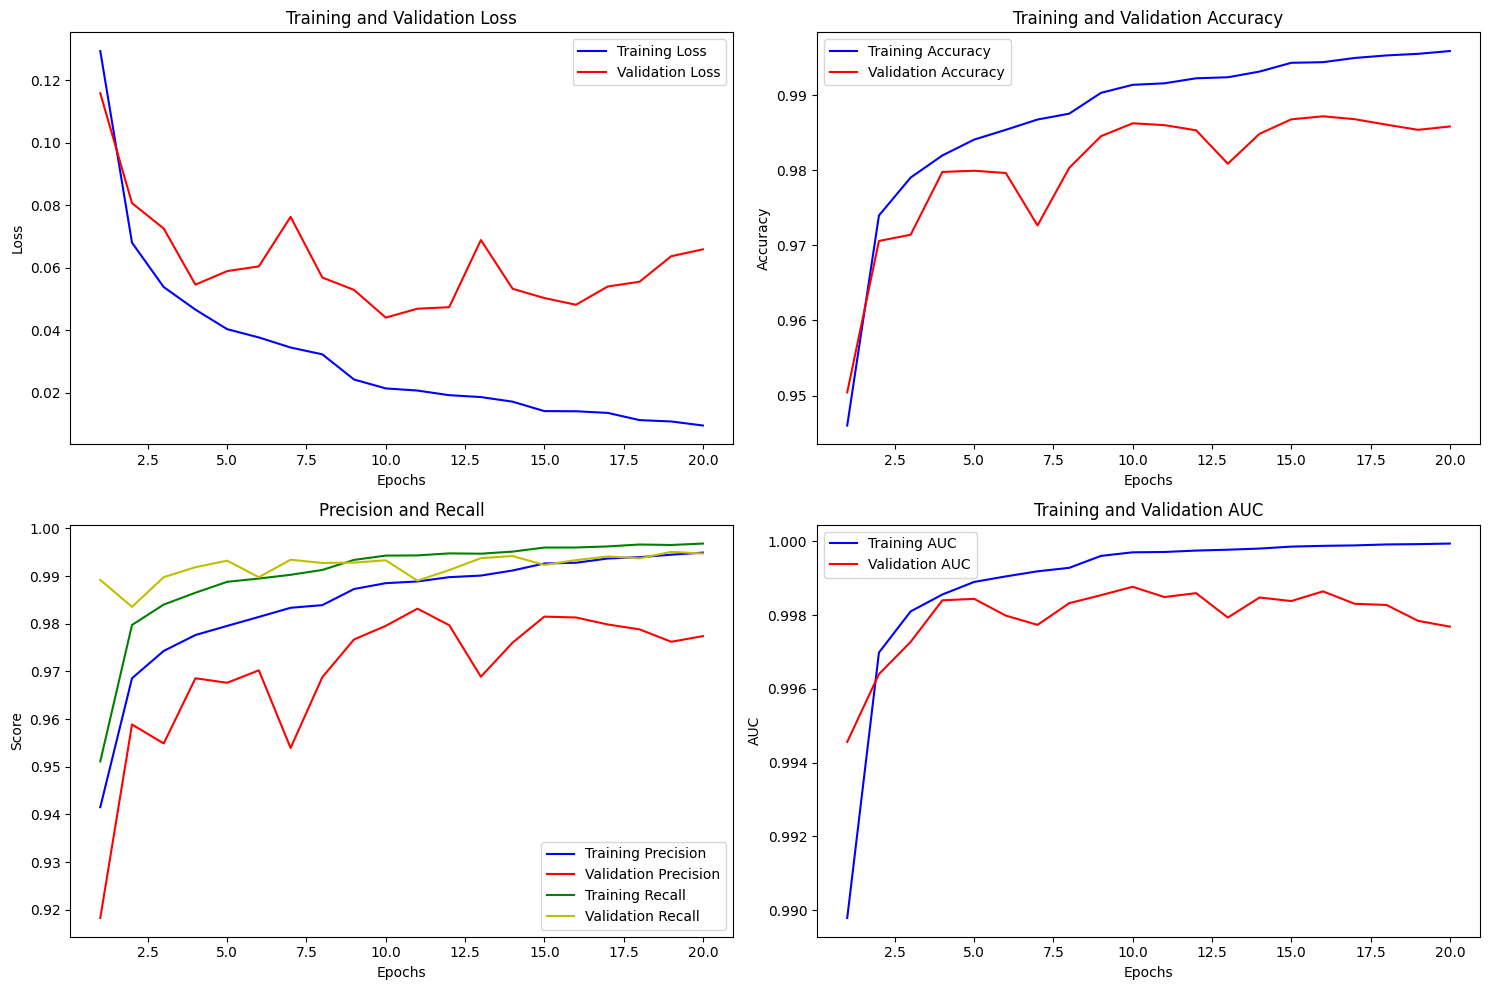

In [21]:
model, history = train_model(
    model=model,
    train_loader=train_data,
    val_loader=validation_data,
    num_epochs=20,
    lr=1e-4,
    device=device,
    save_dir="checkpoints"
)

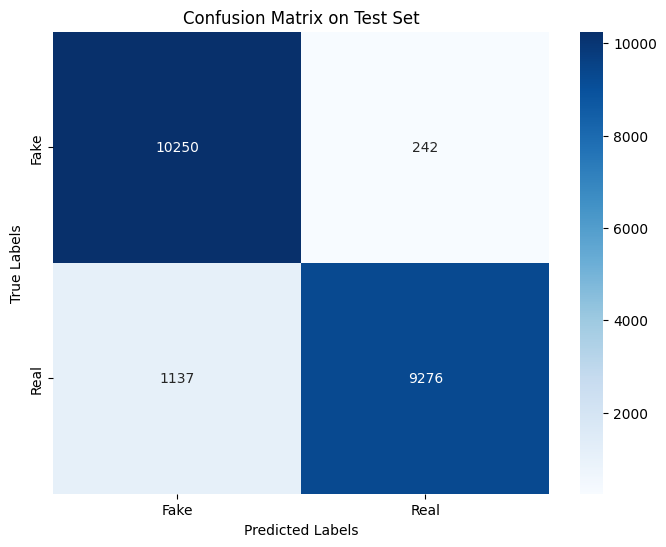

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, dataloader, device):
    model.eval()
    
    true_labels = []
    predictions = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).int()
            
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())
    
    cm = confusion_matrix(true_labels, predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix on Test Set')
    plt.show()
    
    
plot_confusion_matrix(model, test_data, device)

In [23]:
def predict_image(image_path, model, transform, device):
    # Load the image
    image = Image.open(image_path).convert('RGB')
    
    # Apply the transformation
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move the tensor to the appropriate device
    input_tensor = input_tensor.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Perform inference
    with torch.no_grad():
        output = model(input_tensor).squeeze()
        probability = torch.sigmoid(output).item()
    
    # Determine the class
    prediction = "Real" if probability >= 0.5 else "Fake"
    
    return prediction, probability

In [33]:
image_path = 'dataset/test/fake/fake_10.jpg'
la, _ = predict_image(image_path=image_path, model=model, transform=val_test_transform, device=device)
print(f"Prediction: {la}")

Prediction: Fake


In [34]:
image_path = 'dataset/test/real/real_10.jpg'
la, _ = predict_image(image_path=image_path, model=model, transform=val_test_transform, device=device)
print(f"Prediction: {la}")

Prediction: Real
